__mlmachine - Part 1: Overview, Data Intake & EDA__

1. [What is mlmachine?](#What-is-mlmachine?)
1. [The Machine Class - A Hub With Many Spokes](#The-Machine-Class-A-Hub-With-Many-Spokes)
    1. [Pandas dtype != mlm dtype](#Pandas-dtype-!=-mlm-dtype)
1. [Because EDA is Tedious and Takes Forever](#Because-EDA-is-Tedious-and-Takes-Forever)
    1. [Continuous Features](#Continuous-Features)
    1. [Categorical Features](#Categorical-Features)

In [ ]:
# standard libary and settings
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
import sklearn.datasets as datasets
import mlmachine as mlm
from mlmachine.data import titanic
from mlmachine.features.preprocessing import DataFrameSelector, PandasTransformer, PandasFeatureUnion

---
# What is mlmachine?
---
<br><br>
Notebooks often serve as scratch paper for data scientists. Machine learning experiments tend to become messy, disjointed series of hard-coded blocks. Even if time is taken to write general purpose functions, those functions live isolated, uselessly locked away from new projects.

mlmachine is a Python package that facilitates clean and organized notebook-based machine learning experimentation and accomplishes many key aspects of the experimentation life cycle.

The central hub of mlmachine is the `Machine` class. A `Machine` object retains the dataset, target data and feature meta data, and has numerous built-in methods for quickly executing key parts of the experimentation workflow. A user can easily accomplish:
<br><br>
1. Data intake & `mlm_dtype` identification
<br><br>
2. Exploratory data analysis
<br><br>

```python
mlmachine_demo.eda_cat_target_cat_feat(
    feature="Embarked",
    legend_labels=["Died","Survived"],
)
```
<br><br>
![alt text](images/p1_eda_panel.jpeg "EDA Panel")
<br><br>
3. Data preparation & feature engineering
<br><br>
4. Feature selection
<br><br>
```python
fs.feature_selector_results_plot(
    scoring="accuracy",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
    marker_on=False,
)
```
<br><br>
![alt text](images/p1_feature_selection.jpeg "Feature Selection")
<br><br>
5. Hyperparameter tuning with Bayesian optimization
<br><br>
Plus, all of this occurs in a framework that keeps data in a Pandas `DataFrame`. See how the output differs simply by wrapping `PandasTransformer` around the Scikit-learn `OneHotEncoder` class in this example:
<br><br>
![alt text](images/p1_pandastransformer.jpeg "PandasTransformer")
<br><br>

To see mlmachine in action, follow the article series:
<br><br>
[Part 1 - Overview, Data Intake & EDA](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_1.ipynb)
<br><br>
[Part 2 - Pandas In / Pandas Out Pipelines](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_2.ipynb)
<br><br>
[Part 3 - Data Preparation & Feature Engineering](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_3.ipynb)
<br><br>
[Part 4 - Feature Selection](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_4.ipynb)
<br><br>
[Part 5 - Hyperparameter Tuning with Bayesian Optimization](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_5.ipynb)
<br><br>
Let's proceed with Part 1.
<br><br>

<a id = 'What-is-mlmachine?'></a>

---
# The Machine Class - A Hub With Many Spokes
---
<br><br>
We start by instantiating a Machine object:
<br><br>

<a id = 'The-Machine-Class-A-Hub-With-Many-Spokes'></a>

In [ ]:
df_train, df_valid = titanic()

mlmachine_titanic = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings={"Pclass": [1, 2, 3]},
    is_classification=True,
)

Feature summary Feature vs. target summary Target proportion 
 
 
 Embarked 
 Count 
 Proportion 
 
 
 
 
 S 
 644 
 72.440945 
 
 
 C 
 168 
 18.897638 
 
 
 Q 
 77 
 8.661417 
 
 
 
 
 
 Embarked 
 Died 
 Survived 
 
 
 
 
 C 
 75 
 93 
 
 
 Q 
 47 
 30 
 
 
 S 
 427 
 217 
 
 
 
 
 
 Class 
 C 
 Q 
 S 
 
 
 
 
 Died 
 44.642857 
 61.038961 
 66.304348 
 
 
 Survived 
 55.357143 
 38.961039 
 33.695652

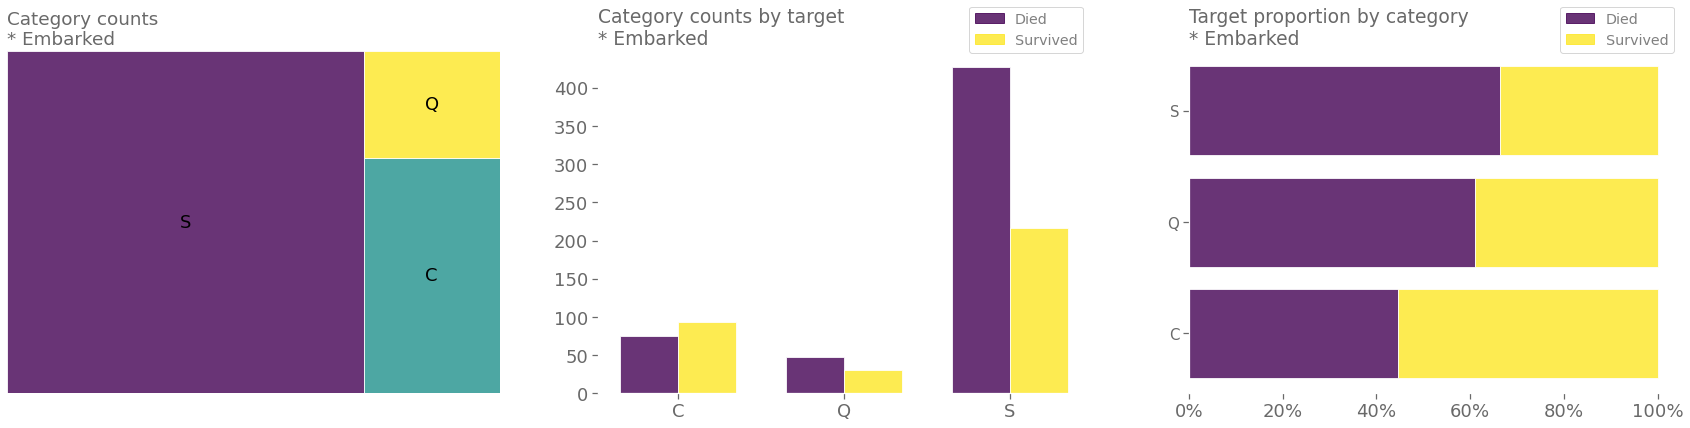

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 Sex 
 Count 
 Proportion 
 
 
 
 
 male 
 577 
 64.758698 
 
 
 female 
 314 
 35.241302 
 
 
 
 
 
 Sex 
 Died 
 Survived 
 
 
 
 
 female 
 81 
 233 
 
 
 male 
 468 
 109 
 
 
 
 
 
 Class 
 female 
 male 
 
 
 
 
 Died 
 25.796178 
 81.109185 
 
 
 Survived 
 74.203822 
 18.890815 
 
 
 
 
 
 z-test statistic 
 p-value 
 
 
 
 
 16.2188 
 0.0

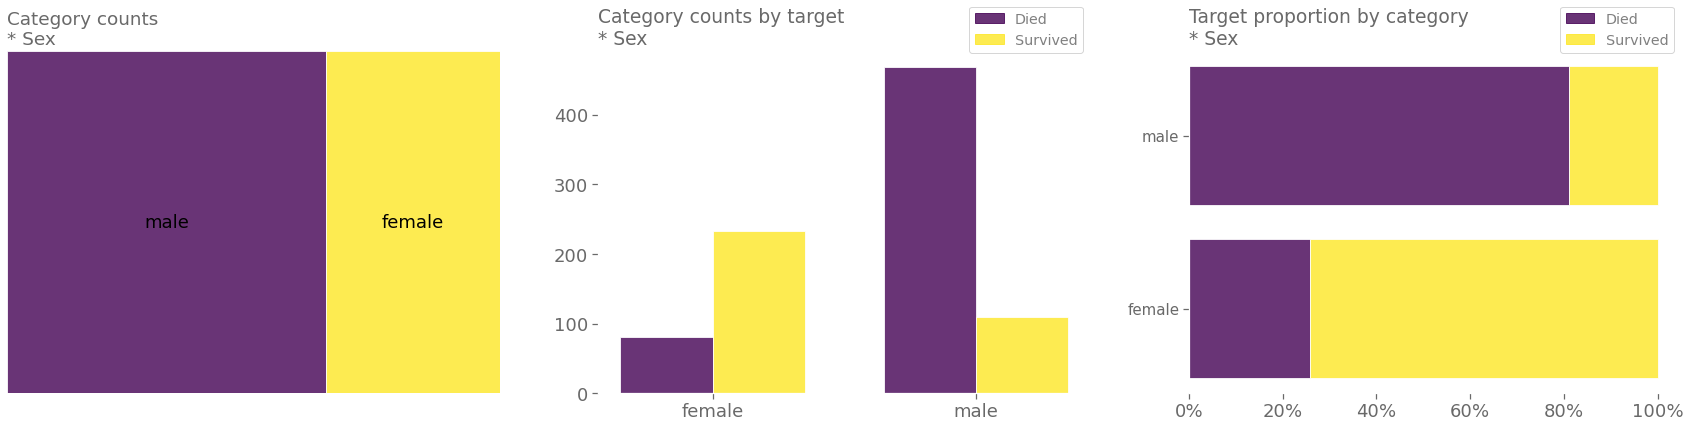

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass 
 Count 
 Proportion 
 
 
 
 
 3 
 491 
 55.106622 
 
 
 1 
 216 
 24.242424 
 
 
 2 
 184 
 20.650954 
 
 
 
 
 
 Pclass 
 Died 
 Survived 
 
 
 
 
 1 
 80 
 136 
 
 
 2 
 97 
 87 
 
 
 3 
 372 
 119 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

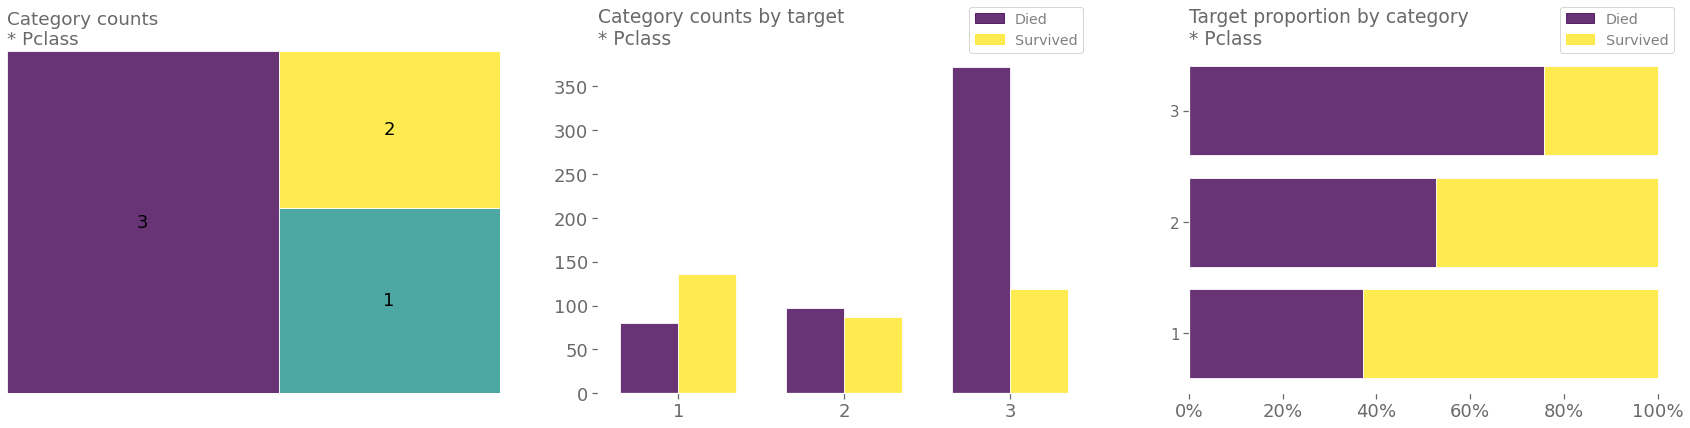

In [11]:
for feature in mlmachine_titanic.data.mlm_dtypes["category"]:
    mlmachine_titanic.eda_cat_target_cat_feat(
        feature=feature,
        legend_labels=["Died","Survived"],
    )

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Age 
 
 
 
 
 count 
 714.000000 
 
 
 mean 
 29.699118 
 
 
 std 
 14.526497 
 
 
 min 
 0.420000 
 
 
 25% 
 20.125000 
 
 
 50% 
 28.000000 
 
 
 75% 
 38.000000 
 
 
 max 
 80.000000 
 
 
 missing 
 177.000000 
 
 
 skew 
 0.388290 
 
 
 kurtosis 
 0.168637 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Died 
 424.0 
 59.383754 
 30.626179 
 14.155388 
 
 
 Survived 
 290.0 
 40.616246 
 28.343690 
 14.925152 
 
 
 
 
 
 z-test statistic 
 p-value 
 
 
 
 
 2.0667 
 0.0388

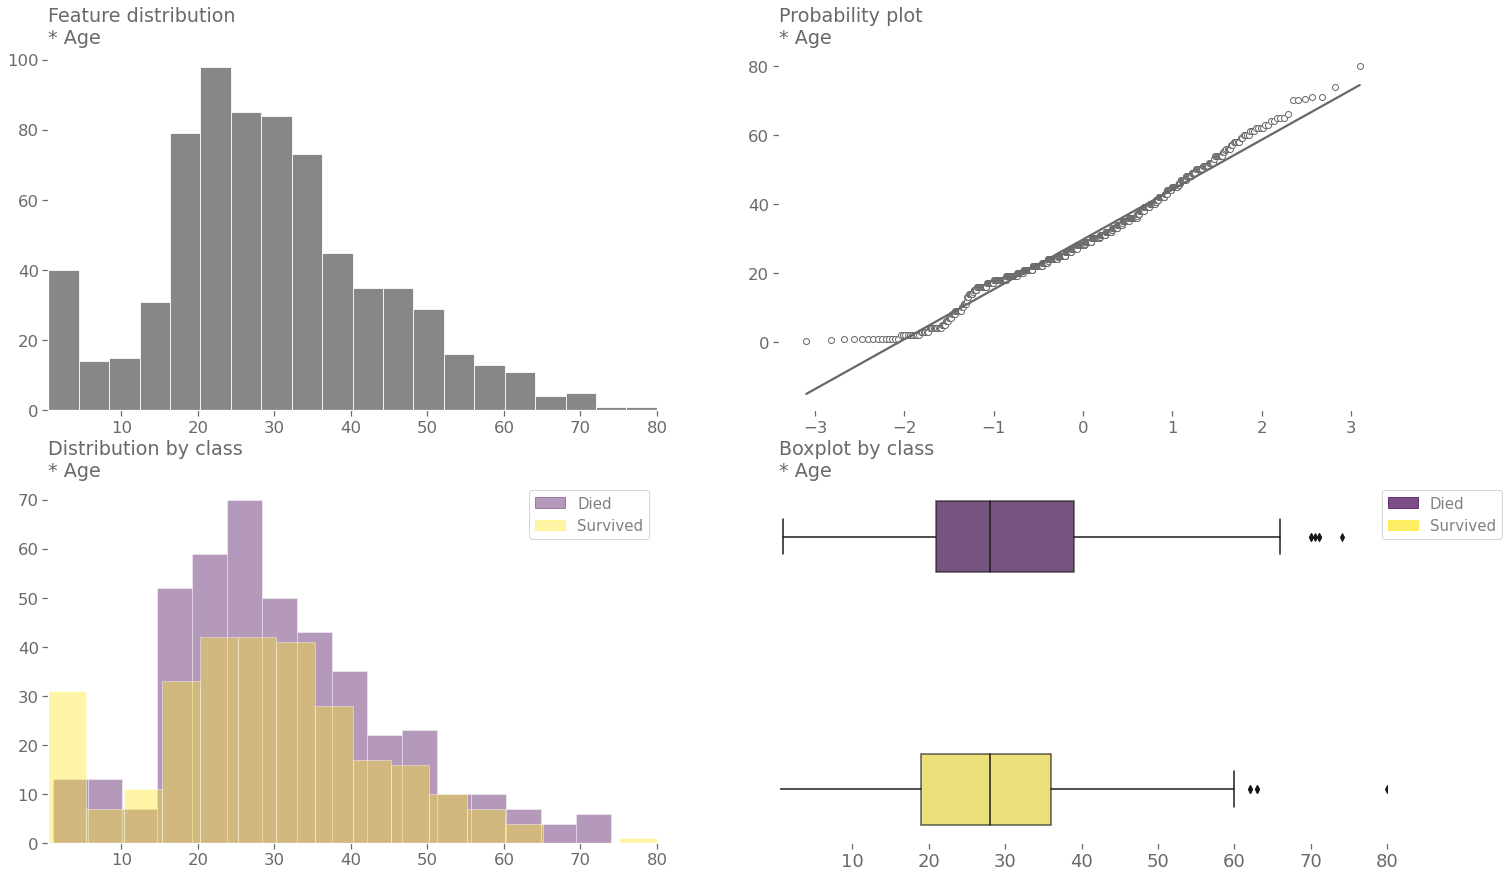

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Fare 
 
 
 
 
 count 
 891.000000 
 
 
 mean 
 32.204208 
 
 
 std 
 49.693429 
 
 
 min 
 0.000000 
 
 
 25% 
 7.910400 
 
 
 50% 
 14.454200 
 
 
 75% 
 31.000000 
 
 
 max 
 512.329200 
 
 
 missing 
 0.000000 
 
 
 skew 
 4.779250 
 
 
 kurtosis 
 33.204289 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Died 
 549.0 
 61.616162 
 22.117887 
 31.359607 
 
 
 Survived 
 342.0 
 38.383838 
 48.395408 
 66.499563 
 
 
 
 
 
 z-test statistic 
 p-value 
 
 
 
 
 -7.9392 
 0.0

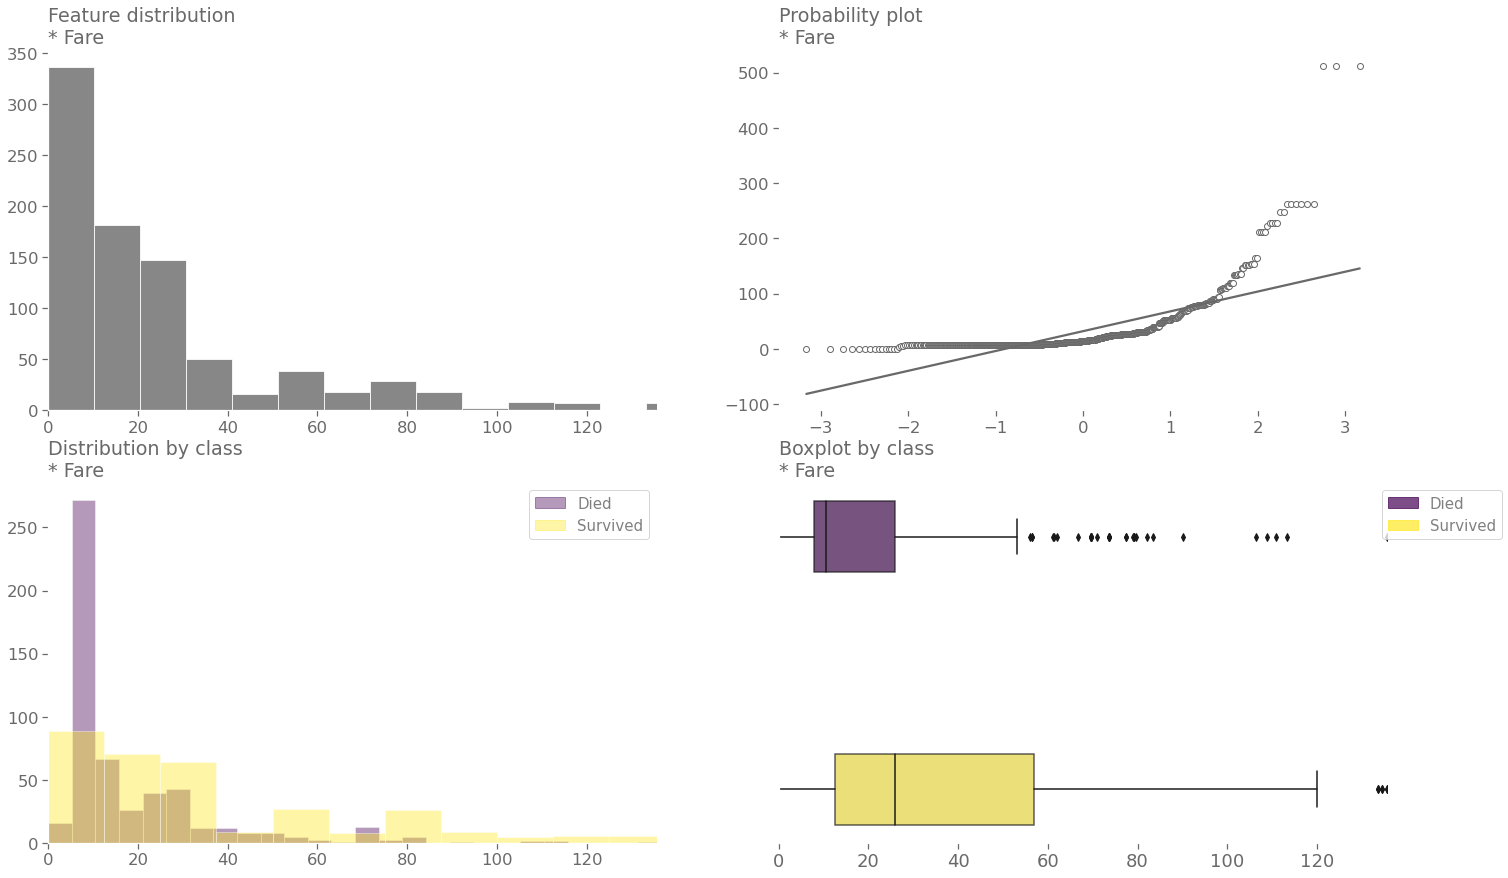

In [6]:
for feature in mlmachine_titanic.data.mlm_dtypes["continuous"]:
    mlmachine_titanic.eda_cat_target_num_feat(
        feature=feature,
        legend_labels=["Died","Survived"],
        outliers_out_of_scope=True,
    )

---
<br><br>
Let's unpack what we just did. Using the canonical Titanic dataset, we instantiated a `Machine` object, called `mlmachine_titanic`, by:

- Passing in the full dataset as a DataFrame
- Specifying the column that contains the target variable
- Specifying the supervised learning task as a classification task
<br><br>

---
<br><br>
The most basic purpose of `mlmachine_titanic` is to maintain our dataset of observations and our target values. Our dataset is stored as a `DataFrame` and can be accessed by calling `mlmachine_titanic.data`:
<br><br>

In [ ]:
mlmachine_titanic.data

---
<br><br>
Our target variable, stored as a named Pandas `Series`, can be accessed just as easily by calling `mlmachine_titanic.target`:
<br><br>

In [ ]:
mlmachine_titanic.target

---
<br><br>
We also passed several lists containing feature names to parameters such as `identify_as_continuous` and `identify_as_nominal`, along with directions on how to encode an ordinal column, and which features to remove. Let's get into the purpose of these parameters.
<br><br>

---
## Pandas dtype != mlm dtype
---
<br><br>
Pandas dtypes describe the values contained within a column, but have no regard for what the values actually mean. Nominal categories, ordinal categories, continuous numbers, counts…it's often impossible to make these distinctions from Pandas dtypes alone. In the world of mlmachine, these distinctions are referred to as `mlm_dtypes`. mlmachine catalogs and, most importantly, updates `mlm_dtypes` as the dataset evolves through feature engineering.
<br><br>
Why does this even matter? Because `mlm_dtypes` inform several key questions throughout the experimentation workflow, namely:
- EDA - which visual types are most effective?
- Imputing - which imputation techniques are most reasonable?
- Encoding - which encoding techniques should be used, if any?
- Feature engineering - which techniques, such as polynomial feature creation, binning and target encoding, should be used, and for which features?
<br><br>

Answers to these questions stem directly from the nature of the feature values. Further, we often want to act upon several features of a certain type at once, which would typically require managing hard-coded lists of feature names. This is a pain.
<br><br>

With that motivation in mind, let's revisit our `Machine` object, mlmachine_titanic. Our `DataFrame`, which we store as `mlmachine_titanic.data`, has a metadata attribute called mlm_dtypes:
<br><br>

<a id = 'Pandas-dtype-!=-mlm-dtype'></a>

In [ ]:
mlmachine_titanic.data.mlm_dtypes

---
<br><br>
Notice the keys of the dictionary. Per the guidance we provided when instantiating the `Machine` object, `mlmachine_titanic.data.mlm_dtypes` is remembering the mlm dtype for each feature. Further, notice we had the option to specify "boolean", "string" and "date" columns if needed. Lastly, the key "category" is a simple concatenation of the keys "nominal", "ordinal" and "boolean" values, and the key "number" is a concatenation of the keys "continuous" and "count" values. These are merely high-level key/value pairs provided for convenience.
<br><br>

We can easily update `mlm_dtypes` to reflect the current state of the dataset. By calling the method `update_mlm_dtypes()`, mlmachine evaluates the features currently in the data and updates `mlm_dtypes` accordingly.
<br><br>

In [ ]:
encode_pipe = PandasFeatureUnion([
    ("nominal_columns", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["nominal"]),
        PandasTransformer(OneHotEncoder()),
    )),
    ("other_columns", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["nominal"]),
    )),
])

mlmachine_titanic.data = encode_pipe.fit_transform(mlmachine_titanic.data.dropna(axis=0))
mlmachine_titanic.update_dtypes()

---
<br><br>
A lot just happened here, and all will become clear in Part 2. For now, focus on the fact that we just one hot encoded our nominal category columns (line 4) and updated our `mlm_dtypes` dictionary. The result of executing `mlmachine_titanic.update_mlm_dtypes()` on line 12 is below. Notice that the value of our "nominal" key has been updated. The original features "Embarked" and "Sex" no longer exist in the dataset, so they no longer exist in `mlm_dtypes`. Instead, these two features have been replaced with their respective dummy columns that were created by `OneHotEncoder`.
<br><br>

In [ ]:
mlmachine_titanic.data.mlm_dtypes

---
<br><br>
mlmachine maintains and modifies these feature type distinctions throughout the life cycle of the experiment. The only requirement is to identify the mlm dtype for each feature from the outset (something we should do every time anyway).
<br><br>

---
# Because EDA is Tedious and Takes Forever
---
<br><br>
We're all guilty of performing a cursory EDA, if any at all ("let's just get to the model training!"). Even with all of the great Python visualization libraries out there, EDA can take a considerable amount of setup. Coding those same, slightly modified functions for the hundredth time is something we all do. And remembering which visual types work best for which feature types and feature/target type combination is not easy.
<br><br>

Skipping EDA is absolutely a mistake, so a portion of mlmachine's functionality is dedicated to quickly making panels that are as beneficial as they are good looking.
<br><br>

We saw one example in the Overview section of this article. Let's look at another:
<br><br>

<a id = 'Because-EDA-is-Tedious-and-Takes-Forever'></a>

---
## Continuous Features
---

<a id = 'Continuous-Features'></a>

In [ ]:
mlmachine_titanic.eda_cat_target_num_feat(
    feature="Age",
    legend_labels=["Died","Survived"],
)

---
<br><br>
`eda_cat_target_num_feat` is a method associated with `mlmachine_titanic` that generates a panel for evaluating a numeric feature in the context of a categorical target. At the top, we display three Pandas DataFrames:
1. Feature Summary - All of the summary statistics we get by executing the standard `df.describe()` command, plus "percent missing", "skew" and "kurtosis".
2. Feature vs. target summary -  Count, proportion, mean and standard deviation of the numeric feature, grouped by the different classes in the target.
3. Statistical test - If the target column only has two classes, this reports the result of a z-test (or t-test, in the case of small samples) and the associated p-value. 
<br><br>

---
<br><br>
Below the summary tables is a panel containing four visualizations. From left to right, starting in the top left corner:
1. Univariate distribution plot of the numeric feature.
2. QQ plot of the numeric feature.
3. Bivariate distribution plot of the numeric feature, faceted by the target.
4. Horizontal box plot, faceted by the target.
<br><br>

---
<br><br>
This visualization function adapts to multi-class problems easily. Let's look at another quick example:
<br><br>

In [ ]:
dataset = datasets.load_wine()
dataset = pd.merge(
            pd.DataFrame(dataset.data, columns=dataset.feature_names),
            pd.Series(dataset.target, name="Class label"),
            left_index=True,
            right_index=True,
        )

mlmachine_wine = mlm.Machine(
    data=dataset,
    identify_as_continuous=list(dataset.columns[:-1]),
    target="Class label",
    is_classification=True,
)

mlmachine_wine.eda_cat_target_num_feat(
    feature="alcalinity_of_ash",
)

---
<br><br>
We created this using the Scikit-learn wine dataset with the same minimal code. Notice the changes:
1. The "Feature vs. target summary" table expands to reflect all three classes.
2. The faceted plots expand to visualize all three classes.
3. The x-axis and y-axis tick labels are decimals rather than whole numbers. This modification happens dynamically under the hood based on the scale of the data being visualized. Less time formatting, more time exploring.
<br><br>

---
## Categorical Features
---
<br><br>
Before finishing Part 1 of this series, let's revisit the teaser EDA panel from the beginning. Instead of looking at the nominal category feature "Embarked" again, let's look at "SibSp" instead, which is a count feature:
<br><br>

<a id = 'Categorical-Features'></a>

In [ ]:
mlmachine_titanic.eda_cat_target_cat_feat(
    feature="SibSp",
    legend_labels=["Died","Survived"],
)

---
<br><br>
`eda_cat_target_cat_feat` generates a panel for a categorical or count feature in the context of a categorical target. Again, there are three summary tables at the top:
1. Feature Summary - Simple count of each level in the category, along with the percent of values each level constitutes in the feature.
2. Feature vs. target summary - Count of each level in the category, grouped by the classes in the target
3. Target proportion - The percent of values of a particular feature level, grouped by the classes in the target.
<br><br>

---
<br><br>
The panel includes three visualization. From left to right:
1. Tree map of the categorical feature.
2. Bar chart of the categorical feature, faceted by the target.
3. 100% horizontal stacked bar chart, faceted by the target.
<br><br>

---
<br><br>
Let's close out by taking one last look at the Scikit-learn wine dataset, this time using `eda_cat_target_cat_feat` to visualize a numeric feature that has been segmented into 5 bins, effectively making it a categorical column:
<br><br>

In [ ]:
binner = KBinsDiscretizer(n_bins=5, encode="ordinal")

mlmachine_wine.data["alcalinity_of_ash"] = binner.fit_transform(
    mlmachine_wine.data["alcalinity_of_ash"].values.reshape(-1, 1)
)

mlmachine_wine.eda_cat_target_cat_feat(
    feature="alcalinity_of_ash",
)

---
<br><br>
Each component of the panel adapts accordingly to the multi-class problem in this dataset.
<br><br>
Continue to [Part 2](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_2.ipynb)
<br><br>